# Experiments with the LIME interpretation model part 2: neural networks

This is the **second part of my blog post on the LIME interpretation model**. For a reminder of what LIME is and its purpose, please read the [first part](https://nkthiebaut.github.io/lime-of-words.html). This second part is a quick **application of the same algorithm to a deep learning (LSTM) model**, while the first part was focused on explaining the predictions of a random forest. 

In [1]:
import pandas as pd
df = pd.read_csv('../content/labeledTrainData.tsv', sep='\t')
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [2]:
from sklearn.model_selection import train_test_split

texts_train, texts_test, y_train, y_test = \
    train_test_split(df["review"].values, df['sentiment'].values, random_state=42)

## Modelling with LSTM

In this example of LIME usage I use a Long Short-Term Memory (LSTM) network to predict the sentiment (positive or negative) associated with an IMDB movie review. LSTM is a specific kind of recurrent neural network that is well explained rather informally [here](http://www.wildml.com/2015/10/recurrent-neural-network-tutorial-part-4-implementing-a-grulstm-rnn-with-python-and-theano/), and more in a more detailed way [there](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

### Preprocessing
In order to preprocess text in a convenient way that can be easily handled by the LIME library, I build a scikit-learn [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object that handles a list of texts as input and returns the prediction of a neural network, thanks to the [Keras](https://keras.io) scikit-learn API.

Pipelines combine various Transformer objects to transform data from raw input to a predicted output. In our case we have to define 2 custom Transformers to translate input text in a form that can be handled by our LSTM. The first transformer takes a list of texts as input and outputs a list of indices lists, for instance ```[["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]].```

The second transformer harmonizes input lengths to a given *maxlen*, padding with zeros if the sequence is too short, and cropping the beginning of the sequence if it is too long. 

After application of those 2 Transformers we end up with a matrix of shape *(n_samples, maxlen)*, readily usable by Keras models. 

In [3]:
vocab_size = 20000  # Max number of different word, i.e. model input dimension
maxlen = 80  # Max number of words kept at the end of each text

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator

class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list 
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        
sequencer = TextsToSequences(num_words=vocab_size)

Using TensorFlow backend.


In [5]:
class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length. 
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros"""
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)

### LSTM construction and training

We now simply have to chain our preprocessing Transformers and our LSTM model. Here I have chosen a rather standard network with 128 hidden units, and dropout rate of 50 %. We only train during 2 epochs.

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

batch_size = 64
max_features = vocab_size + 1

def create_model(max_features):
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.5)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=2, batch_size=batch_size, 
                               max_features=max_features, verbose=1)

pipeline = make_pipeline(sequencer, padder, sklearn_lstm)

In [7]:
%%time
history = pipeline.fit(texts_train, y_train)

Epoch 1/2
18750/18750 [==============================] - 235s - loss: 0.5142 - acc: 0.7501      

In [8]:
from sklearn import metrics
y_preds = pipeline.predict(texts_test)

print('Accuracy: {:.2f} %'.format(100*metrics.accuracy_score(y_preds, y_test)))

6250/6250 [==============================] - 25s      128/6250 [..............................] - ETA: 30s

 Performances are similar to the *TF-IDF + Random forest* model of the previous post (82% accuracy). Hence we do not have enough data to leverage the modelling power of our LSTM, but this example is enough to illustrate the usage of LIME for a deep learning model. As before we choose an example and compute feature importance with the LIME package. 

In [10]:
# We choose a sample from test set
idx = 1
text_sample = texts_test[idx]
class_names = ['negative', 'positive']

print(text_sample)
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[y_test[idx]])

This film pulls you in from the get-go because it grabs our attention by acknowledging, yeah, that this story is opening with a cliché  a funeral.<br /><br />In hands other than Judi's I wouldn't have given it an 8 as this material has been done over and over again: The great reunion of a once famous, pick one please, team, army platoon, theatre group, singers, band.<br /><br />But this movie never stoops to cheap sentimentalization, and when you think it is going to it swoops off in another direction. A case in point is the flowers that are sent by an admirer to Judi.<br /><br />The band members are an interesting group and ride above the clichés too. One is in jail, one has found religion, one is an alkie, and one has sunk into dementia. But the joie de vivre rediscovered by Judi, ignited by her granddaughter's interest, carries us along and makes us overlook the sometimes simplistic nature of the plot.<br /><br />The cast are a who's who of talent, Leslie Caron, the incomparable ja

/Users/nthiebaut/anaconda/envs/nlp/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


5000/5000 [==============================] - 19s      128/5000 [..............................] - ETA: 17s

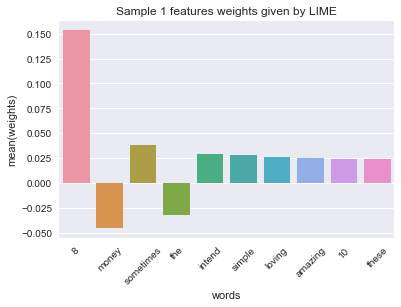

In [12]:
import seaborn as sns
%matplotlib inline
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

sns.barplot(x="words", y="weights", data=lime_weights);
plt.xticks(rotation=45)
plt.title('Sample {} features weights given by LIME'.format(idx));

As for the first model, we get an ensemble of 10 explanation features that make sense. While we were having a way to interpret individual predictions with the random forest model, here LIME has no simple specific equivalent for recurrent neural networks.

## Conclusion